In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
data = []
with open("yelp_academic_dataset_review.json", "r") as f:
    for i, line in enumerate(f):
        if i >= 75000:
            break
        data.append(json.loads(line))
df = pd.DataFrame(data) 


In [18]:
review_df = df[['stars', 'text']].astype({'stars': int})
review_df

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...
...,...,...
74995,4,Very cool store!! I've never been to one of th...
74996,5,I have been meaning to write a review for this...
74997,5,This place has MIND-BLOWINGLY good tacos and f...
74998,3,They give you large snowball sizes for little ...


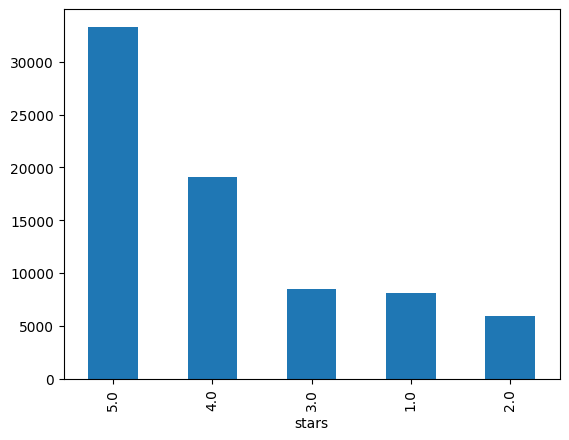

In [6]:
# inspect distribution of classes
df['stars'].value_counts().plot(kind='bar')
plt.show()

In [19]:
# randomly sample from each class based on how many samples the minority class holds
seed = 42
minority_class_count = len(review_df[review_df.loc[:, ('stars')] == 2])
review_df = review_df.groupby('stars').apply(lambda x: x.sample(n=minority_class_count, random_state=seed)).reset_index(drop=True)
review_df

,stars,text
0,1,"I, only gave 1 star because based on the appea..."
1,1,Wouldn't go here again..... I got my belly but...
2,1,Some of the reviews have mentioned how long it...
3,1,"Ok, I hate to give a place one star and I gene..."
4,1,i wish i could have given it a zero or a negat...
...,...,...
29840,5,Great place for drinks (I've never had food he...
29841,5,My girlfriend and I just had a delightful lunc...
29842,5,Gorgeous and stylish. Comfortable and clean. T...
29843,5,Had a great time at BR! Our server Reyna? was ...
